# introduction
Did the markets expect the invasion on February 24th 04:06 UTC+1? Here, we gauge the market-implied expectations of the russia-ukraine conflict escalation.

# assumptions
* agents are risk-neutral

In [84]:
import pandas as pd
import numpy as np
from tensorflow_probability import distributions as tfd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.dates import DateFormatter, DayLocator, HourLocator
from tqdm.notebook import tqdm

from optools.blackscholes import option_price as bs_price
from optools.rnd import fit_lognormal_mix

from src.setup import *
from src.datafeed_.downstream import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
# settings
# parameters
TAU = 1/12  # maturity of options

# matplotlib
palette = plt.rcParams['axes.prop_cycle'].by_key()['color']

# frames
def format_dataframe(df_: pd.DataFrame, tail=True):
    """A little formatter helper."""
    if tail:
        return format_dataframe(df_.tail(), tail=False)
    if df_.columns.nlevels > 1:
        col_key = ("date", "")
    else:
        col_key = "date"
    res_ = df_.reset_index()\
        .style.format(formatter={col_key: lambda x: x.strftime("%Y-%m-%d %H:%M")},
                      precision=2)\
        .hide(axis=0)
    return res_


# data
Spot quotes of USDRUB at 1-min frequency (GMT+1 time) are from Bloomberg.

In [3]:
# load spot data
d_spot = get_spot_data()

format_dataframe(d_spot.set_index("date"), tail=True)

date,spot
2022-02-28 16:46,109.50
2022-02-28 16:47,109.61
2022-02-28 16:48,109.54
2022-02-28 16:49,107.90
2022-02-28 16:50,107.82


Events and their timestamps (GMT+1) are from Bloomberg.

In [4]:
# load events data
d_events = get_timeline()

format_dataframe(d_events, tail=False)

date,event
2022-02-24 04:06,putin announces special military operation
2022-02-18 22:58,biden warns russia planning attack in coming days
2022-02-17 15:19,biden estimate prob of invasion as very high
2022-02-11 20:03,jake sullivan believes putin has decided to invade next week
2022-02-11 11:34,blinken warns russia can attack during the olympics


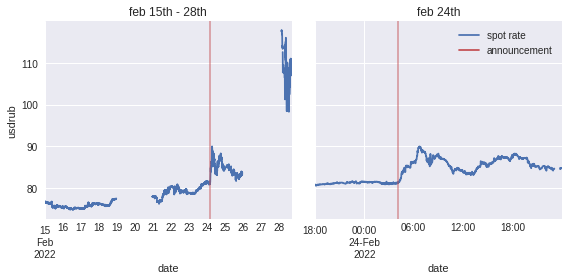

In [5]:
# plot dynamics
to_plot = d_spot.set_index("date").squeeze()\
    .resample("1T").asfreq()\
    .rename("usdrub")
dt_t = d_events.index[0]

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(8, 4))
ax[0].set_title("feb 15th - 28th")
ax[0].set_ylabel("usdrub")
ax[1].set_title("feb 24th")

to_plot.loc["2022-02-15":].plot(ax=ax[0])
to_plot.loc["2022-02-23 18:00":"2022-02-24"].plot(ax=ax[1])
for ax_ in ax:
    ax_.axvline(x=dt_t, color=palette[2], label="announcement", alpha=0.5)

# legend
leg_handles = [
    mlines.Line2D([], [], color=palette[0], label="spot rate"),
    mlines.Line2D([], [], color=palette[2], label="announcement")
]
ax[1].legend(handles=leg_handles)

fig.tight_layout()
plt.show()

Forward quotes and USD OIS rates are from Bloomberg; RUB rates are implied from the covered interest rate parity for USDRUB:
$$ F = S \times \frac{1 + r_{rub}}{1 + r_{usd}} $$

In [6]:
# forward and rates data
data_forward = get_forward_data()
data_rates = get_rates_data()

format_dataframe(data_rates.set_index("date"), tail=True)

date,div_yield,rf
2022-02-28 16:50,0.00,0.35
2022-02-28 16:51,0.00,nan
2022-02-28 16:52,0.00,nan
2022-02-28 16:53,0.00,nan
2022-02-28 16:54,0.00,nan


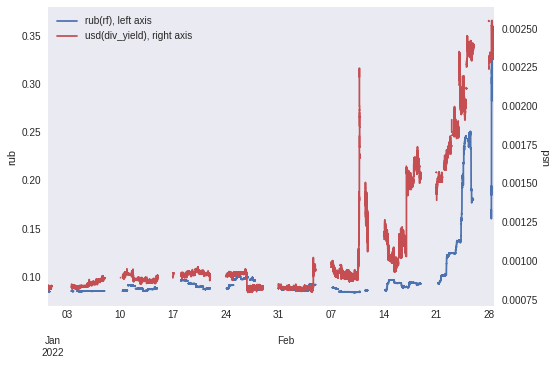

In [7]:
# plot
to_plot = data_rates\
    .set_index("date")\
    .resample("1T").asfreq()

# two axes
fig, ax_l = plt.subplots()
ax_r = ax_l.twinx()
to_plot["rf"].plot(ax=ax_l, color=palette[0])
to_plot["div_yield"].plot(ax=ax_r, color=palette[2])
# legend
leg_handles = [
    mlines.Line2D([], [], color=palette[0], label="rub(rf), left axis"),
    mlines.Line2D([], [], color=palette[2], label="usd(div_yield), right axis")
]
ax_l.grid(False)
ax_r.grid(False)
ax_l.legend(handles=leg_handles, loc="upper left")
ax_l.set_xlabel("", visible=False)
ax_l.set_ylabel("rub")
ax_r.set_ylabel("usd")
plt.show()

Options data is in the form of strikes and corresponding Black-Scholes implied volatilities for each date.

In [8]:
# options data
data_opt = get_option_data()

format_dataframe(data_opt.sort_values("date"), tail=True)

index,strike,date,vol
5800,182.59,2022-02-28 16:44,1.23
17402,83.90,2022-02-28 16:44,0.79
23203,84.27,2022-02-28 16:44,0.77
11601,136.68,2022-02-28 16:44,1.00
30109,109.07,2022-02-28 16:44,0.85


# estimating risk-neutral density
We start with the parametric fitted density. For each date, we take the five available strike prices and corresponding Black-Scholes volatilities, compute the option prices and fit the mixture of 2 log-normal distributions by minimizing the weighted sum of squared errors:
$$ \min_{\theta} \left\Vert C(K, F, \sigma, y | \theta) - c \right\Vert^2, $$
where $C(\cdot | \theta)$ is the option pricing function parametrized by $\theta$ and $c$ are the observed option quotes.

**the following takes long!**

In [ ]:
# data, setting datetime index where necessary
data_opt = get_option_data()
data_forward = get_forward_data().set_index("date").squeeze()
data_rates = get_rates_data().set_index("date")
e_dt = get_timeline().index[0]  # time of the invasion announcement

# fit mixture
mix_theta = dict()

for dt, dt_grp in tqdm(data_opt.query("date < @e_dt").groupby("date")):
    
    # ignore incomplete groups
    if len(dt_grp) < 5:
        continue
    
    f_, r_ = data_forward.loc[dt], data_rates.loc[dt]
    k_, v_ = dt_grp["strike"].values, dt_grp["vol"].values

    # compute option prices first
    c_price = bs_price(
        strike=k_, vol=v_, forward=f_,
        rf=r_["rf"], div_yield=r_["div_yield"],
        is_call=True, tau=TAU
    )

    # initial values
    x0_ = np.array(
        [0.34] + [np.log(f_) - v_.mean() ** 2 / 2] * 2 + [v_.mean()] * 2
    )

    # fit!
    mfit = fit_lognormal_mix(
        option_price=c_price, strike=k_, is_call=True,
        forward=f_, rf=r_["rf"],
        x0=x0_, weights=np.array([2, 1, 1, 1, 1, 1])
    )

    mix_theta[dt] = mfit.copy()

In [42]:
# to df
mix_theta = pd.DataFrame\
    .from_dict(mix_theta, orient="index",
               columns=["w", "mu1", "mu2", "sigma1", "sigma2"])\
    .rename_axis(index="date")

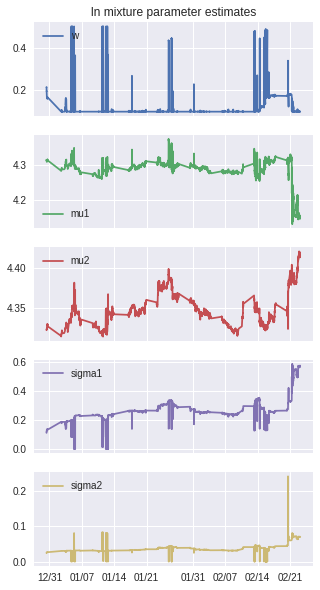

In [43]:
# take a look at the estimated parameters
fig, ax = plt.subplots(5, 1, figsize=(5, 10), sharex=True)

mix_theta.plot(ax=ax, subplots=True)

for ax_ in ax[:-1]:
    ax_.set_xticklabels([])
    ax_.set_xlabel("", visible=False)

ax[-1].set_xlabel("", visible=False)
ax[-1].xaxis.set_major_formatter(DateFormatter("%m/%d"))
ax[0].set_title("ln mixture parameter estimates")

plt.show()

Following the announcement on the morning of Feb 24th, 2022, USDRUB settled at the level of approx. 85, as can be seen in the figure above. Assuming this is what the market participants had had in mind for the fair level of USDRUB upon realization of an invasion, let's calculate the implied probability of this level or higher in the lead-up to this announcement.

In [ ]:
# function to calculate P[S > 85] for every timestamp
def prob_getter(x_):
    mx = tfd.Mixture(
        cat=tfd.Categorical(probs=[x_[0], 1.-x_[0]]),
        components=[
          tfd.LogNormal(loc=x_[1], scale=x_[3]),
          tfd.LogNormal(loc=x_[2], scale=x_[4]),
    ])
    res_ = 1 - mx.cdf(85).numpy()
    return res_

**the following takes a while**

In [ ]:
# calculate!
prob = mix_theta.apply(prob_getter, axis=1)

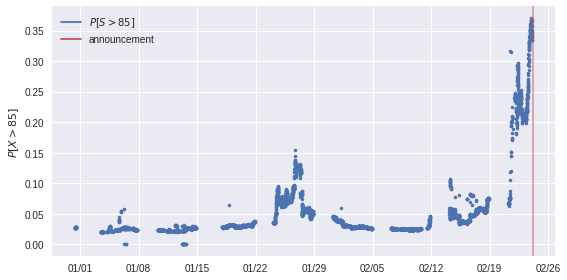

In [85]:
# plot
to_plot = prob

fig, ax = plt.subplots(figsize=(8, 4))

to_plot.plot(ax=ax, linestyle="none", marker=".")
ax.axvline(x=dt_t, color=palette[2], label="announcement", alpha=0.5)

ax.set_ylabel(r"$P[X > 85]$")
ax.set_xlabel("", visible=False)

# legend
leg_handles = [
    mlines.Line2D([], [], color=palette[0], label=r"$P[S>85]$"),
    mlines.Line2D([], [], color=palette[2], label="announcement")
]
ax.legend(handles=leg_handles)

ax.set_xticklabels(ax_.get_xticklabels(), rotation=0, ha="center")
ax.xaxis.set_major_locator(DayLocator(interval=7))
ax.xaxis.set_major_formatter(DateFormatter("%m/%d"))

fig.tight_layout()
plt.show()

Let's zoom in on February 23-24th...

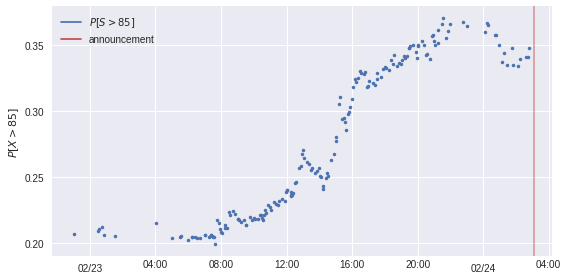

In [86]:
fig, ax = plt.subplots(figsize=(8, 4))

to_plot.loc["2022-02-23":"2022-02-24"].plot(ax=ax, linestyle="none", marker=".")

ax.axvline(x=dt_t, color=palette[2], label="announcement", alpha=0.5)

ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="center")
ax.set_yticks(np.arange(0.2, 0.4, 0.05))
ax.set_ylabel(r"$P[X > 85]$")
ax.set_xlabel("", visible=False)

ax.xaxis.set_major_locator(DayLocator([23, 24]))
ax.xaxis.set_minor_locator(HourLocator([0, 4, 8, 12, 16, 20]))
ax.xaxis.set_major_formatter(DateFormatter("%m/%d"))
ax.xaxis.set_minor_formatter(DateFormatter("%H:%M"))
ax.grid(which="both", axis="both", visible=True)

ax.legend(handles=leg_handles)

fig.tight_layout()
plt.show()